# Simulator Class Demo - M2M Sleep-Based Random Access

**Author:** [Removed]  
**Date:** February 10, 2026  
**Task:** 1.2 - Simulator Class Implementation

This notebook demonstrates the discrete-event simulator for sleep-based random access with slotted Aloha.

## Features
- Multi-node simulation
- Collision detection
- Comprehensive metrics
- Batch replications
- Parameter sweeps

In [1]:
# Add project root to path (works from repo root or examples/)
import os
import sys
import subprocess

_path = os.path.abspath(os.getcwd())
for _ in range(10):
    if os.path.isdir(os.path.join(_path, "src")) and os.path.exists(os.path.join(_path, "requirements.txt")):
        break
    _path = os.path.dirname(_path)
else:
    _path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if _path not in sys.path:
    sys.path.insert(0, _path)

def _ensure_deps():
    try:
        import matplotlib
        import numpy
        import seaborn
    except ImportError:
        req = os.path.join(_path, "requirements.txt")
        print("Installing dependencies into this Python...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", req])
        print("Done. Re-run this cell.")
_ensure_deps()

from src.simulator import Simulator, BatchSimulator, SimulationConfig
from src.node import NodeState
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Modules imported successfully!")

Modules imported successfully!


## 1. Basic Simulation

Run a single simulation with 10 nodes.

In [2]:
# Configure power rates
power_rates = {
    'PT': 10.0,   # Transmit
    'PB': 5.0,    # Busy
    'PI': 1.0,    # Idle
    'PW': 2.0,    # Wakeup
    'PS': 0.1     # Sleep
}

# Create simulation config
config = SimulationConfig(
    n_nodes=10,
    arrival_rate=0.01,         # λ = 0.01
    transmission_prob=0.1,     # q = 0.1
    idle_timer=10,             # ts = 10 slots
    wakeup_time=5,             # tw = 5 slots
    initial_energy=5000.0,
    power_rates=power_rates,
    max_slots=10000,
    seed=42
)

# Run simulation
sim = Simulator(config)
result = sim.run_simulation(track_history=True, verbose=True)

Starting simulation with 10 nodes...
Parameters: λ=0.01, q=0.1, ts=10, tw=5

Simulation complete! Total time: 0.27s
Simulated 10000 slots


## 2. Results Summary

In [4]:
print("="*60)
print("SIMULATION RESULTS")
print("="*60)

print(f"\nSimulation Parameters:")
print(f"  Nodes (n): {result.config.n_nodes}")
print(f"  Arrival rate (λ): {result.config.arrival_rate}")
print(f"  Transmission prob (q): {result.config.transmission_prob}")
print(f"  Idle timer (ts): {result.config.idle_timer}")
print(f"  Wakeup time (tw): {result.config.wakeup_time}")

print(f"\nNetwork Performance:")
print(f"  Total slots: {result.total_slots}")
print(f"  Packet arrivals: {result.total_arrivals}")
print(f"  Packet deliveries: {result.total_deliveries}")
print(f"  Delivery rate: {result.total_deliveries/max(result.total_arrivals,1)*100:.1f}%")
print(f"  Throughput: {result.throughput:.4f} pkts/slot")

print(f"\nDelay Statistics (slots):")
print(f"  Mean delay: {result.mean_delay:.2f}")
print(f"  95th percentile: {result.tail_delay_95:.2f}")
print(f"  99th percentile: {result.tail_delay_99:.2f}")

print(f"\nCollision Statistics:")
print(f"  Total transmissions: {result.total_transmissions}")
print(f"  Total collisions: {result.total_collisions}")
print(f"  Success probability (p): {result.empirical_success_prob:.4f}")

print(f"\nEnergy & Lifetime:")
print(f"  Mean lifetime: {result.mean_lifetime_years:.4f} years")
print(f"  Mean energy consumed: {result.mean_energy_consumed:.2f} units")

print(f"\nState Fractions:")
for state, fraction in result.state_fractions.items():
    print(f"  {state.capitalize()}: {fraction*100:.1f}%")

print("="*60)

SIMULATION RESULTS

Simulation Parameters:
  Nodes (n): 10
  Arrival rate (λ): 0.01
  Transmission prob (q): 0.1
  Idle timer (ts): 10
  Wakeup time (tw): 5

Network Performance:
  Total slots: 10000
  Packet arrivals: 981
  Packet deliveries: 979
  Delivery rate: 99.8%
  Throughput: 0.0979 pkts/slot

Delay Statistics (slots):
  Mean delay: 15.34
  95th percentile: 37.10
  99th percentile: 56.00

Collision Statistics:
  Total transmissions: 1058
  Total collisions: 39
  Success probability (p): 0.0979

Energy & Lifetime:
  Mean lifetime: 0.0000 years
  Mean energy consumed: 4378.06 units

State Fractions:
  Active: 10.6%
  Idle: 8.2%
  Sleep: 77.4%
  Wakeup: 3.9%


## 3. Time Series Visualization

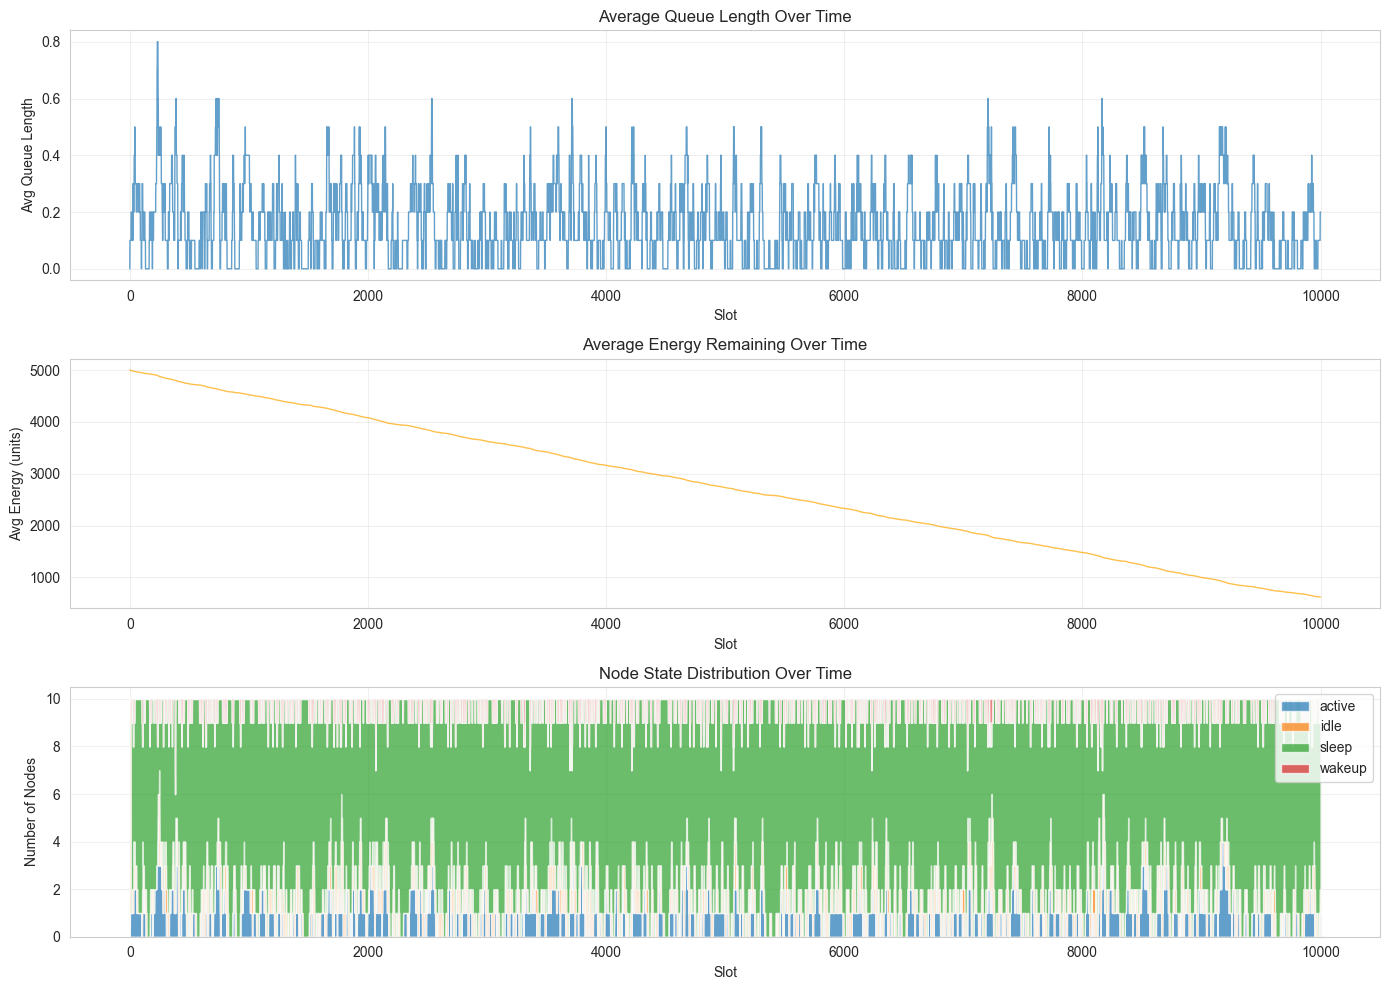

In [5]:
# Plot queue length over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Queue length
axes[0].plot(result.queue_length_history, linewidth=1, alpha=0.7)
axes[0].set_xlabel('Slot')
axes[0].set_ylabel('Avg Queue Length')
axes[0].set_title('Average Queue Length Over Time')
axes[0].grid(True, alpha=0.3)

# Energy depletion
axes[1].plot(result.energy_history, linewidth=1, color='orange', alpha=0.7)
axes[1].set_xlabel('Slot')
axes[1].set_ylabel('Avg Energy (units)')
axes[1].set_title('Average Energy Remaining Over Time')
axes[1].grid(True, alpha=0.3)

# State distribution over time
states = ['active', 'idle', 'sleep', 'wakeup']
state_data = {state: [] for state in states}

for state_dict in result.state_history:
    for state in states:
        state_data[state].append(state_dict.get(state, 0))

# Stacked area plot
axes[2].stackplot(
    range(len(result.state_history)),
    [state_data[s] for s in states],
    labels=states,
    alpha=0.7
)
axes[2].set_xlabel('Slot')
axes[2].set_ylabel('Number of Nodes')
axes[2].set_title('Node State Distribution Over Time')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. State and Energy Breakdown

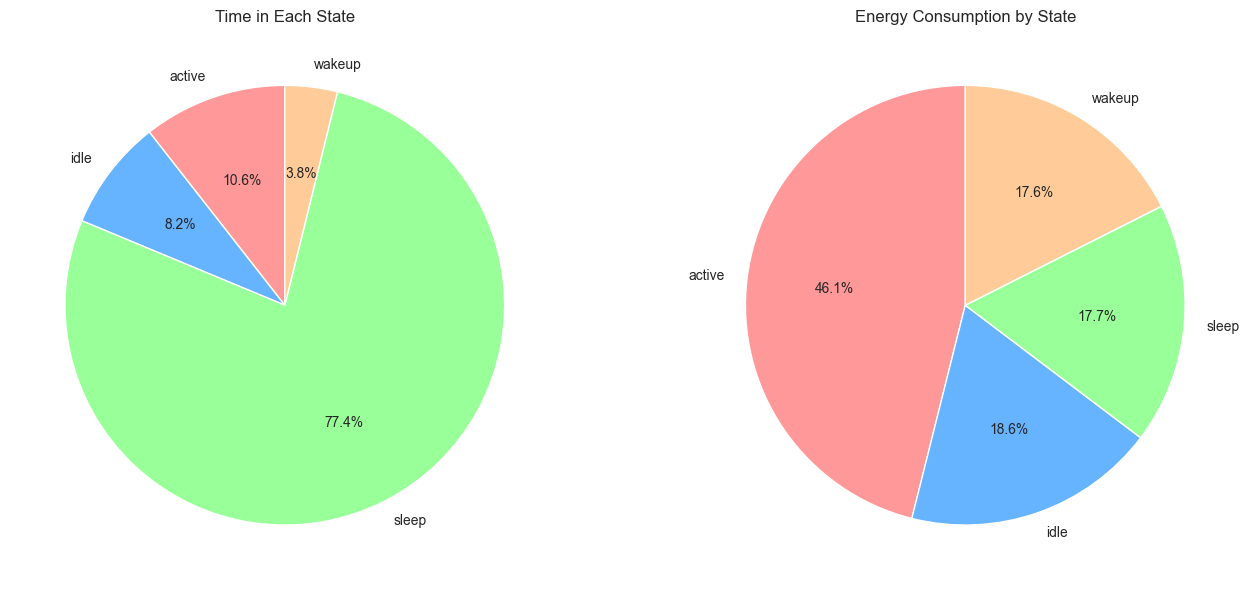

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# State fractions pie chart
labels = list(result.state_fractions.keys())
sizes = list(result.state_fractions.values())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Time in Each State')

# Energy consumption by state
energy_labels = list(result.energy_fractions_by_state.keys())
energy_sizes = list(result.energy_fractions_by_state.values())

axes[1].pie(energy_sizes, labels=energy_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Energy Consumption by State')

plt.tight_layout()
plt.show()

## 5. Batch Replications

Run multiple replications to get confidence intervals.

In [10]:
# Create base config
base_config = SimulationConfig(
    n_nodes=10,
    arrival_rate=0.01,
    transmission_prob=0.1,
    idle_timer=10,
    wakeup_time=5,
    initial_energy=5000.0,
    power_rates=power_rates,
    max_slots=5000,
    seed=None
)

# Run replications
batch_sim = BatchSimulator(base_config)
print("Running 20 replications...")
results = batch_sim.run_replications(n_replications=20, verbose=True)

# Aggregate results
aggregated = BatchSimulator.aggregate_results(results)

# Units for display
METRIC_UNITS = {
    'mean_delay': 'slots', 'tail_delay_95': 'slots', 'tail_delay_99': 'slots',
    'mean_lifetime_years': 'years', 'throughput': 'pkts/slot', 'mean_queue_length': 'pkts',
    'empirical_success_prob': '', 'empirical_service_rate': '', 'total_collisions': 'count',
}
print("\n" + "="*60)
print("AGGREGATED RESULTS (Mean ± Std)")
print("="*60)
for metric, (mean, std) in aggregated.items():
    if metric == 'mean_lifetime_years':
        # Use human-readable units (hours/days/years) so short lifetimes don't show as 0
        print(f"{metric}: {BatchSimulator.format_lifetime(mean, std)}")
    else:
        unit = METRIC_UNITS.get(metric, '')
        suf = f" {unit}" if unit else ""
        print(f"{metric}: {mean:.4f} ± {std:.4f}{suf}")
print("="*60)

Running 20 replications...
Running 20 replications...
  Completed 5/20 replications
  Completed 10/20 replications
  Completed 15/20 replications
  Completed 20/20 replications

AGGREGATED RESULTS (Mean ± Std)
mean_delay: 15.6279 ± 0.8399 slots
tail_delay_95: 38.9675 ± 3.0102 slots
tail_delay_99: 57.8550 ± 6.0406 slots
mean_lifetime_years: 0.02 ± 0.00 hours
throughput: 0.1003 ± 0.0042 pkts/slot
mean_queue_length: 0.1200 ± 0.0980 pkts
empirical_success_prob: 0.1003 ± 0.0042
empirical_service_rate: 0.0911 ± 0.0046
total_collisions: 25.4500 ± 5.5810 count


## 6. Parameter Sweep: Transmission Probability (q)

Investigate the impact of transmission probability on delay and lifetime.

In [11]:
# Sweep transmission probability
q_values = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3]

print(f"Running parameter sweep for q in {q_values}...")
sweep_results = batch_sim.parameter_sweep(
    param_name='transmission_prob',
    param_values=q_values,
    n_replications=10,
    verbose=True
)

Running parameter sweep for q in [0.02, 0.05, 0.1, 0.15, 0.2, 0.3]...
Parameter sweep: transmission_prob
Values: [0.02, 0.05, 0.1, 0.15, 0.2, 0.3]
Replications per value: 10

transmission_prob = 0.02
  Mean delay: 121.52 ± 18.42 slots
  Mean lifetime: 0.01 ± 0.00 hours

transmission_prob = 0.05
  Mean delay: 30.40 ± 1.61 slots
  Mean lifetime: 0.02 ± 0.00 hours

transmission_prob = 0.1
  Mean delay: 15.72 ± 0.71 slots
  Mean lifetime: 0.02 ± 0.00 hours

transmission_prob = 0.15
  Mean delay: 11.46 ± 0.60 slots
  Mean lifetime: 0.02 ± 0.00 hours

transmission_prob = 0.2
  Mean delay: 9.33 ± 0.17 slots
  Mean lifetime: 0.02 ± 0.00 hours

transmission_prob = 0.3
  Mean delay: 7.32 ± 0.15 slots
  Mean lifetime: 0.02 ± 0.00 hours


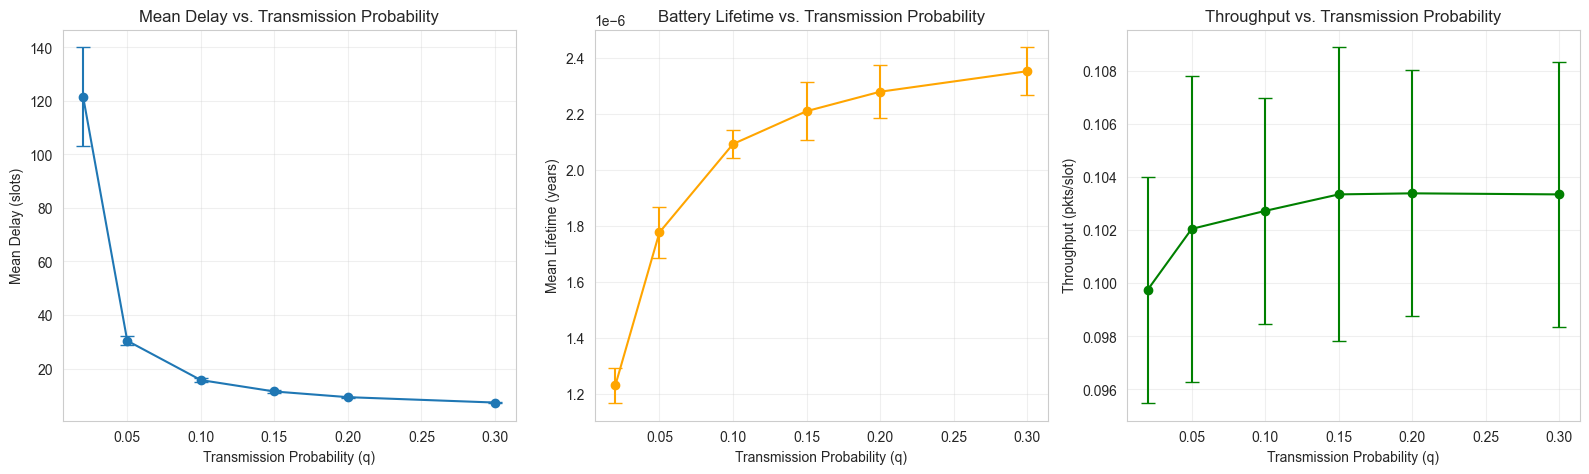

In [12]:
# Extract metrics for plotting
q_vals = []
mean_delays = []
mean_delays_std = []
mean_lifetimes = []
mean_lifetimes_std = []
throughputs = []
throughputs_std = []

for q in q_values:
    results = sweep_results[q]
    q_vals.append(q)
    
    delays = [r.mean_delay for r in results]
    mean_delays.append(np.mean(delays))
    mean_delays_std.append(np.std(delays))
    
    lifetimes = [r.mean_lifetime_years for r in results]
    mean_lifetimes.append(np.mean(lifetimes))
    mean_lifetimes_std.append(np.std(lifetimes))
    
    thru = [r.throughput for r in results]
    throughputs.append(np.mean(thru))
    throughputs_std.append(np.std(thru))

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Delay vs q
axes[0].errorbar(q_vals, mean_delays, yerr=mean_delays_std, marker='o', capsize=5)
axes[0].set_xlabel('Transmission Probability (q)')
axes[0].set_ylabel('Mean Delay (slots)')
axes[0].set_title('Mean Delay vs. Transmission Probability')
axes[0].grid(True, alpha=0.3)

# Lifetime vs q
axes[1].errorbar(q_vals, mean_lifetimes, yerr=mean_lifetimes_std, marker='o', capsize=5, color='orange')
axes[1].set_xlabel('Transmission Probability (q)')
axes[1].set_ylabel('Mean Lifetime (years)')
axes[1].set_title('Battery Lifetime vs. Transmission Probability')
axes[1].grid(True, alpha=0.3)

# Throughput vs q
axes[2].errorbar(q_vals, throughputs, yerr=throughputs_std, marker='o', capsize=5, color='green')
axes[2].set_xlabel('Transmission Probability (q)')
axes[2].set_ylabel('Throughput (pkts/slot)')
axes[2].set_title('Throughput vs. Transmission Probability')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Trade-off Analysis: Delay vs. Lifetime

Visualize the fundamental trade-off between latency and battery life.

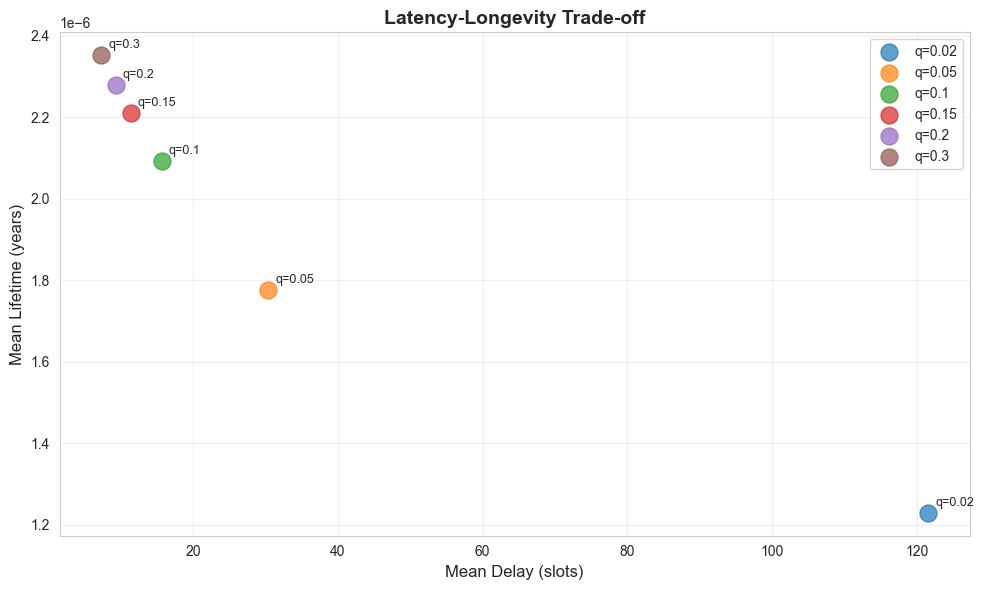


Observation: Higher transmission probability (q) reduces delay but also reduces lifetime.
This demonstrates the fundamental trade-off in M2M communications.


In [13]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot delay vs lifetime for each q value
for i, q in enumerate(q_values):
    plt.scatter(
        mean_delays[i],
        mean_lifetimes[i],
        s=150,
        alpha=0.7,
        label=f'q={q}'
    )
    
    # Add text annotation
    plt.annotate(
        f'q={q}',
        (mean_delays[i], mean_lifetimes[i]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.xlabel('Mean Delay (slots)', fontsize=12)
plt.ylabel('Mean Lifetime (years)', fontsize=12)
plt.title('Latency-Longevity Trade-off', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nObservation: Higher transmission probability (q) reduces delay but also reduces lifetime.")
print("This demonstrates the fundamental trade-off in M2M communications.")

## 8. Idle Timer (ts) Impact

Sweep idle timer to see its effect on performance.

In [14]:
# Sweep idle timer
ts_values = [1, 5, 10, 20, 50]

print(f"Running parameter sweep for ts in {ts_values}...")
ts_sweep_results = batch_sim.parameter_sweep(
    param_name='idle_timer',
    param_values=ts_values,
    n_replications=10,
    verbose=True
)

Running parameter sweep for ts in [1, 5, 10, 20, 50]...
Parameter sweep: idle_timer
Values: [1, 5, 10, 20, 50]
Replications per value: 10

idle_timer = 1
  Mean delay: 16.51 ± 0.81 slots
  Mean lifetime: 0.02 ± 0.00 hours

idle_timer = 5
  Mean delay: 16.13 ± 0.49 slots
  Mean lifetime: 0.02 ± 0.00 hours

idle_timer = 10
  Mean delay: 15.72 ± 0.71 slots
  Mean lifetime: 0.02 ± 0.00 hours

idle_timer = 20
  Mean delay: 15.39 ± 0.48 slots
  Mean lifetime: 0.02 ± 0.00 hours

idle_timer = 50
  Mean delay: 14.04 ± 0.45 slots
  Mean lifetime: 0.01 ± 0.00 hours


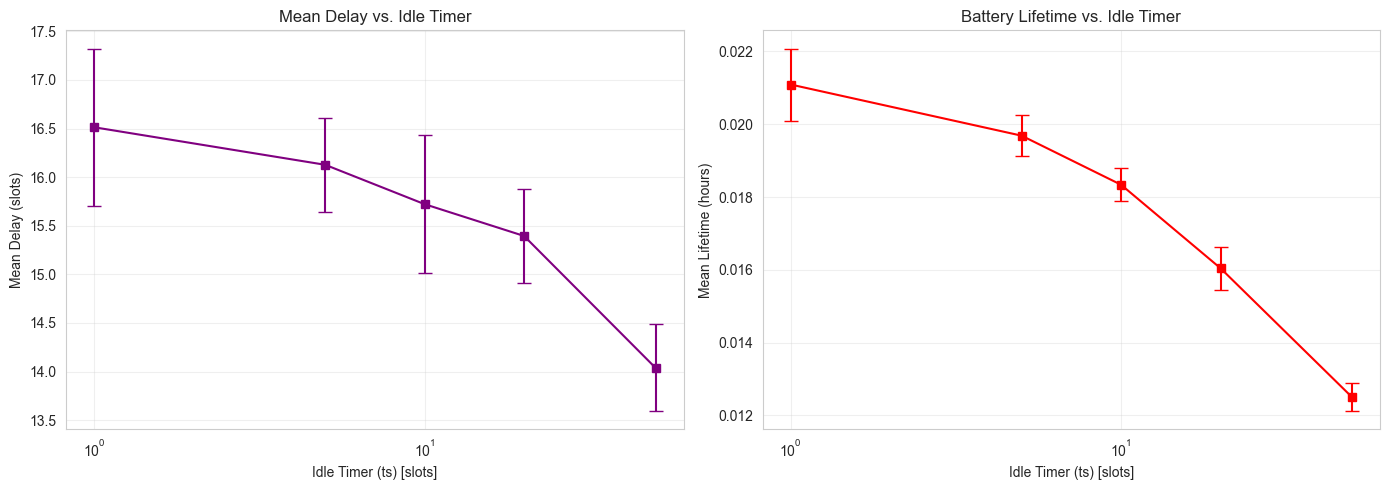


Observation: Longer idle timer (ts) increases lifetime by promoting sleep,
but may increase delay due to longer wake-up transitions.


In [15]:
# Extract and plot
ts_vals = []
ts_delays = []
ts_delays_std = []
ts_lifetimes = []
ts_lifetimes_std = []

# Derive from sweep results (run the parameter sweep cell above first)
ts_values = sorted(ts_sweep_results.keys())

for ts in ts_values:
    results = ts_sweep_results[ts]
    ts_vals.append(ts)
    
    delays = [r.mean_delay for r in results]
    ts_delays.append(np.mean(delays))
    ts_delays_std.append(np.std(delays))
    
    lifetimes = [r.mean_lifetime_years for r in results]
    ts_lifetimes.append(np.mean(lifetimes))
    ts_lifetimes_std.append(np.std(lifetimes))

# Convert to hours for readable scale (short lifetimes)
HOURS_PER_YEAR = 365.25 * 24
ts_lifetimes_h = np.array(ts_lifetimes) * HOURS_PER_YEAR
ts_lifetimes_h_std = np.array(ts_lifetimes_std) * HOURS_PER_YEAR

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Delay vs ts
axes[0].errorbar(ts_vals, ts_delays, yerr=ts_delays_std, marker='s', capsize=5, color='purple')
axes[0].set_xlabel('Idle Timer (ts) [slots]')
axes[0].set_ylabel('Mean Delay (slots)')
axes[0].set_title('Mean Delay vs. Idle Timer')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)

# Lifetime vs ts (hours)
axes[1].errorbar(ts_vals, ts_lifetimes_h, yerr=ts_lifetimes_h_std, marker='s', capsize=5, color='red')
axes[1].set_xlabel('Idle Timer (ts) [slots]')
axes[1].set_ylabel('Mean Lifetime (hours)')
axes[1].set_title('Battery Lifetime vs. Idle Timer')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: Longer idle timer (ts) increases lifetime by promoting sleep,")
print("but may increase delay due to longer wake-up transitions.")

## Summary

This notebook demonstrated:

1. ✓ Basic simulation with multi-node network
2. ✓ Collision detection and handling
3. ✓ Comprehensive metrics collection
4. ✓ Time series visualization
5. ✓ Batch replications with confidence intervals
6. ✓ Parameter sweeps (q, ts)
7. ✓ Trade-off analysis (delay vs. lifetime)

**Key Findings:**
- Higher transmission probability (q) reduces delay but increases collisions and energy consumption
- Idle timer (ts) controls sleep behavior: larger ts saves energy but may increase wake-up delays
- Clear trade-off between low latency and long battery life

**Task 1.2 Status:** ✓ COMPLETED (Feb 10, 2026)

**Next Steps:**
- Task 1.3: Integrate realistic 3GPP power model
- Task 1.4: Basic testing and debugging